In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
common_props_path = 'commonProps.csv'
common_props_raw: pd.DataFrame = pd.read_csv(common_props_path)
common_props_raw

,runNumber,timePoint,diskLoad,ioChannelLoad,processorsLoad,totalWaitAllocate,useOfPage
0,0,7.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,7.000000,0.000000,0.000000,0.000000,0.0,50.0
2,0,7.000000,0.000000,0.000000,1.690375,0.0,50.0
3,0,7.674719,0.000000,0.000000,1.541766,0.0,50.0
4,0,10.336484,0.000000,0.000000,1.144743,0.0,50.0
...,...,...,...,...,...,...,...
4739604,3,799995.000000,0.005365,0.002144,1.431183,0.0,89.0
4739605,3,799995.000000,0.005365,0.002144,1.431183,0.0,89.0
4739606,3,799999.000000,0.005365,0.002144,1.431176,0.0,89.0
4739607,3,799999.000000,0.005365,0.002144,1.431176,0.0,89.0


In [35]:
common_props_raw.dtypes

runNumber              int64
timePoint            float64
diskLoad             float64
ioChannelLoad        float64
processorsLoad       float64
totalWaitAllocate    float64
useOfPage            float64
dtype: object

In [36]:
time_in_system_file_path = 'timeInSystem.csv'
time_in_system_raw: pd.DataFrame = pd.read_csv(time_in_system_file_path)
time_in_system_raw

,runNumber,timePoint,timeInSystem
0,0,20.224733,13.224733
1,0,32.011596,10.011596
2,0,42.243971,11.243971
3,0,47.782220,7.782220
4,0,58.647718,12.647718
...,...,...,...
457572,3,799961.092440,11.092440
457573,3,799967.900368,8.900368
457574,3,799976.952852,11.952852
457575,3,799980.560641,12.560641


In [37]:
time_in_system_raw.dtypes

runNumber         int64
timePoint       float64
timeInSystem    float64
dtype: object

In [38]:
time_wait_allocate_file_path = 'timeWaitAllocate.csv'
time_wait_allocate_raw: pd.DataFrame = pd.read_csv(time_wait_allocate_file_path, header=0)
time_wait_allocate_raw

,runNumber,timePoint,timeWaitAllocate
0,0,63.603301,0.603301
1,0,145.050171,3.050171
2,0,157.727506,0.727506
3,0,168.229724,18.229724
4,0,177.523849,11.523849
...,...,...,...
13123,3,798800.847610,0.847610
13124,3,798807.947597,2.947597
13125,3,798820.524116,4.524116
13126,3,799512.023494,0.023494


In [39]:
time_wait_allocate_raw.dtypes

runNumber             int64
timePoint           float64
timeWaitAllocate    float64
dtype: object

In [40]:
import numpy as np
from array import array
from typing import Sequence


def calculate_means_through_time(time_points: pd.Series, values: pd.Series) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    values_through_time = array('d')

    for time_point, value in zip(time_points.iloc[1:], values):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += value * delay
        values_through_time.append(value_sum / delay_sum)

    return values_through_time

def calculate_stddevs_through_time(time_points: pd.Series, values: pd.Series, means: array[float]) -> array[float]:
    prev_time_point = time_points.iloc[0]
    delay_sum = 0.0
    value_sum = 0.0

    stddevs_through_time: array[float] = array('d')

    for time_point, value, mean in zip(time_points.iloc[1:], values, means):
        delay = time_point - prev_time_point
        prev_time_point = time_point
        delay_sum += delay
        value_sum += ((value - mean) ** 2) * delay
        stddevs_through_time.append(np.sqrt(value_sum / delay_sum))

    return stddevs_through_time

In [41]:
import attr

@attr.frozen
class PropertyMeanStdDev:
    mean: array[float]
    stdDev: array[float]

def calc_mean_stddev_through_time(time_points: pd.Series, props: pd.Series) -> PropertyMeanStdDev:
    means = calculate_means_through_time(time_points, props)
    return PropertyMeanStdDev(
        means,
        calculate_stddevs_through_time(time_points, props, means)
    )

In [42]:
from collections import deque

time_points_mat: deque[Sequence[float]] = deque()
disk_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
io_channel_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
processors_load_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
use_of_page_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
total_wait_allocate_stddev_mat: deque[PropertyMeanStdDev] = deque()

time_in_system_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_mean_stddev_mat: deque[PropertyMeanStdDev] = deque()
time_in_system_time_points_mat: deque[PropertyMeanStdDev] = deque()
time_wait_allocate_time_points_mat: deque[PropertyMeanStdDev] = deque()

In [43]:
total_runs_num = len(common_props_raw['runNumber'].value_counts())
total_runs_num

4

In [44]:
for run_number in range(total_runs_num):
    common_props_raw_indexed = common_props_raw[common_props_raw['runNumber'] == run_number]
    time_points = common_props_raw_indexed['timePoint'][:-1]
    disk_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['diskLoad']))
    io_channel_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['ioChannelLoad']))
    processors_load_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['processorsLoad']))
    use_of_page_mean_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['useOfPage']))
    total_wait_allocate_stddev_mat.append(calc_mean_stddev_through_time(time_points, common_props_raw_indexed['totalWaitAllocate']))
    time_points_mat.append(time_points[:-1])

    time_in_system_raw_indexed = time_in_system_raw[time_in_system_raw['runNumber'] == run_number]
    time_in_system_time_points = time_in_system_raw_indexed['timePoint']
    time_in_system_mean_stddev_mat.append(calc_mean_stddev_through_time(time_in_system_time_points, time_in_system_raw_indexed['timeInSystem']))
    time_in_system_time_points_mat.append(time_in_system_time_points.iloc[:-1])

    time_wait_allocate_raw_indexed = time_wait_allocate_raw[time_wait_allocate_raw['runNumber'] == run_number]
    time_wait_allocate_time_points = time_wait_allocate_raw_indexed['timePoint']
    time_wait_allocate_mean_stddev_mat.append(calc_mean_stddev_through_time(time_wait_allocate_time_points, time_wait_allocate_raw_indexed['timeWaitAllocate']))
    time_wait_allocate_time_points_mat.append(time_wait_allocate_time_points.iloc[:-1])

/tmp/ipykernel_101795/689705320.py:18: RuntimeWarning: invalid value encountered in scalar divide
  values_through_time.append(value_sum / delay_sum)


In [45]:
from typing import Iterable

def plot_matrix(time_points_mat: Iterable[float], value_mat: Iterable[float], ylabel: str):
    for run_num, row in enumerate(zip(time_points_mat, value_mat)):
        time_points_row = row[0]
        value_row = row[1]
        plt.plot(time_points_row, value_row, label=f'Run {run_num}')

    plt.title(f'{ylabel} vs. TimePoint for Each Run')
    plt.xlabel('TimePoint')
    plt.ylabel(ylabel)
    plt.legend(title='Run Number')
    plt.grid(True)
    plt.show()

def plot_matrix_mean_std_dev(time_points_mat: Sequence[float], value_mat: deque[PropertyMeanStdDev], ylabel: str):
    plot_matrix(time_points_mat, (v.mean for v in value_mat), ylabel + 'Mean')
    plot_matrix(time_points_mat, (v.stdDev for v in value_mat), ylabel + 'StdDev')

/home/sideshowbobgot/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


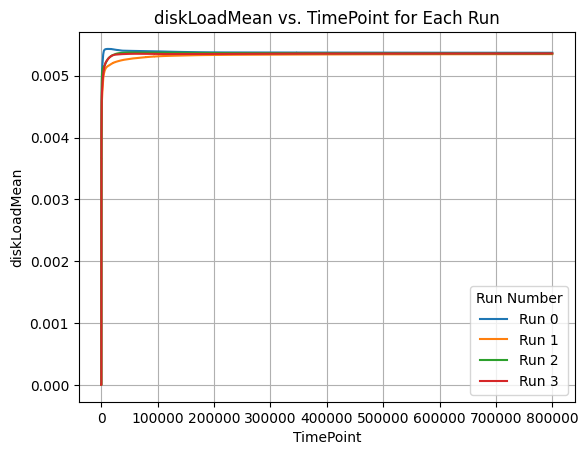

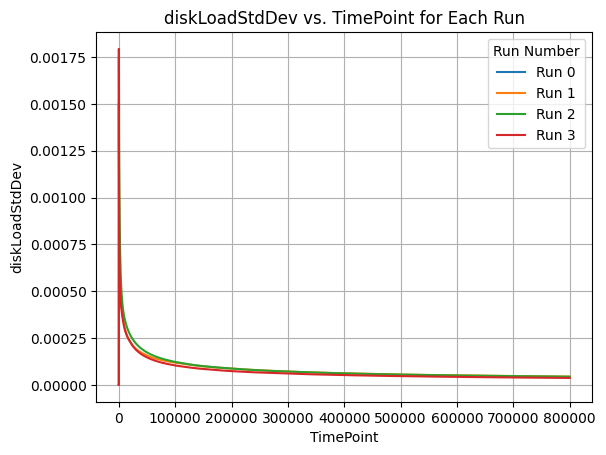

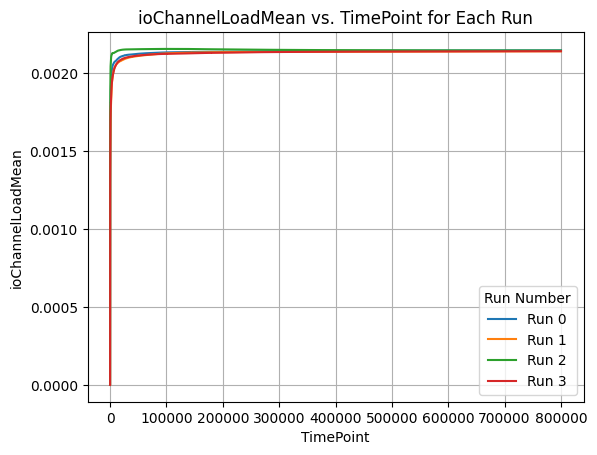

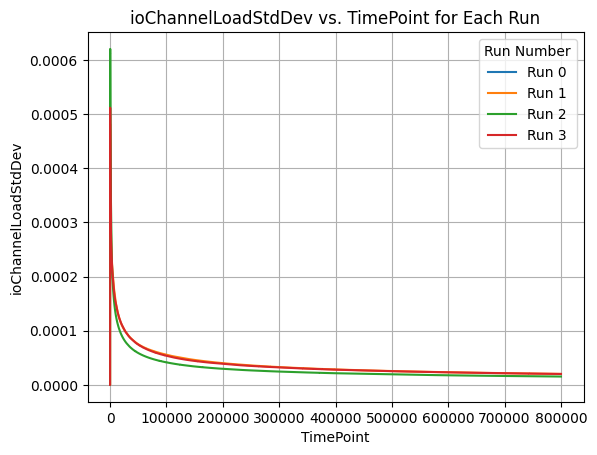

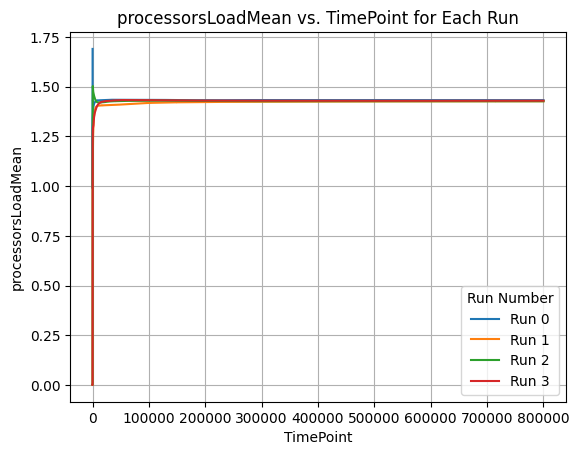

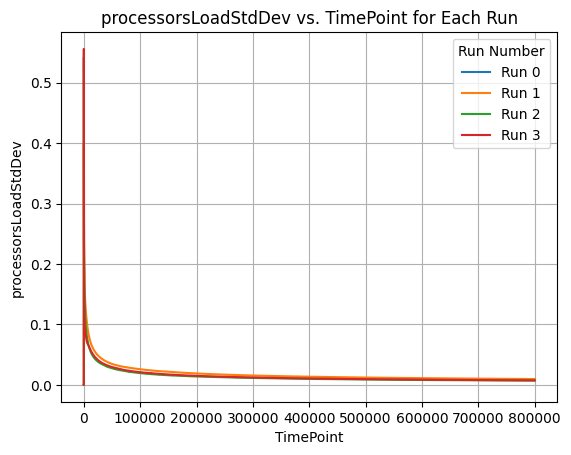

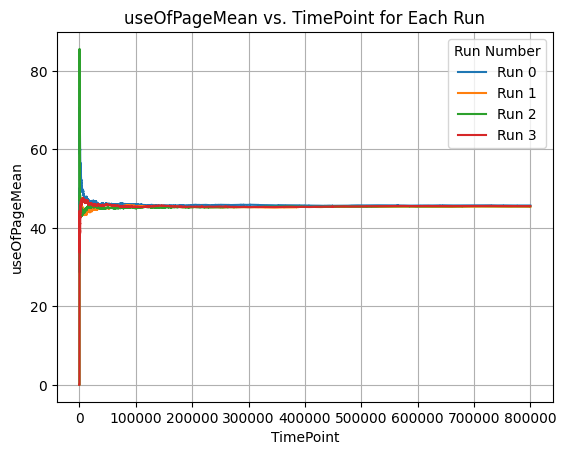

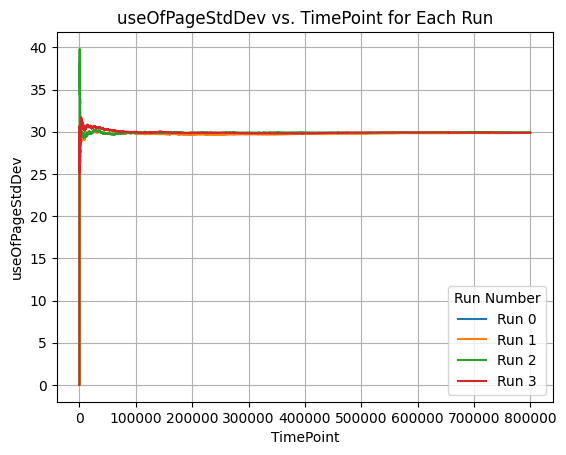

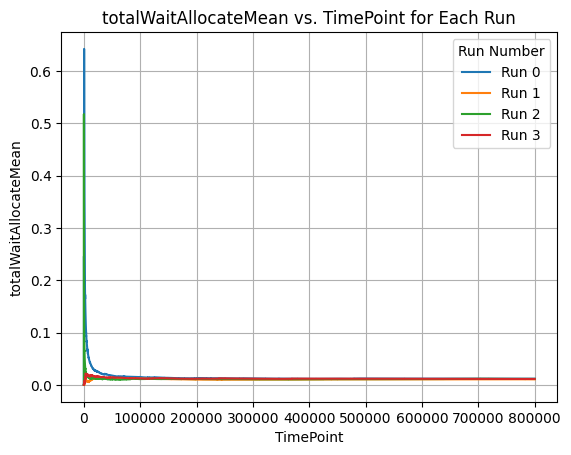

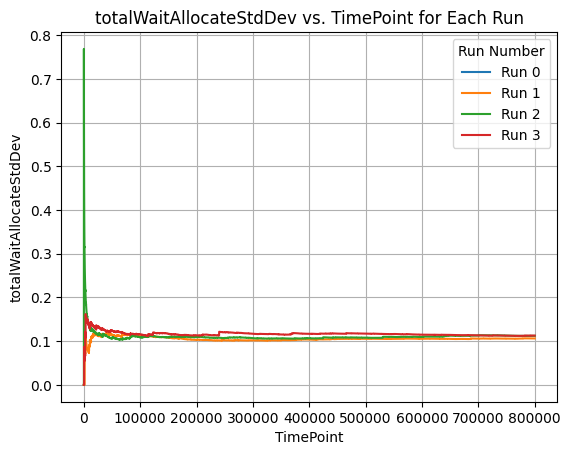

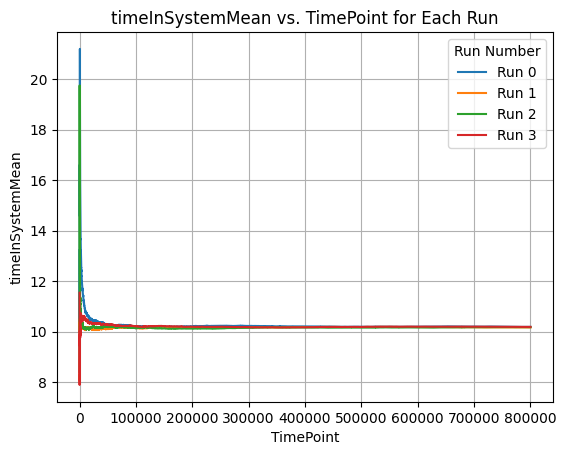

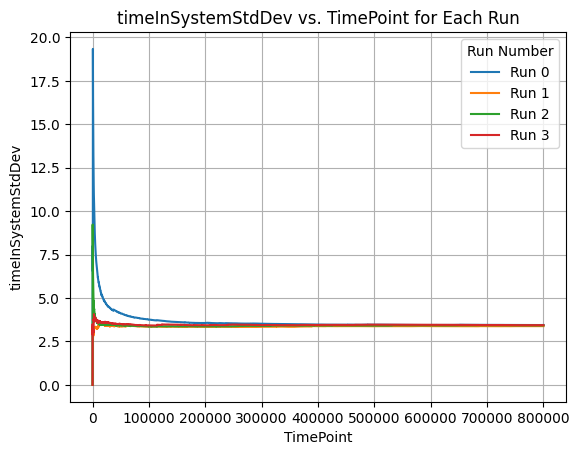

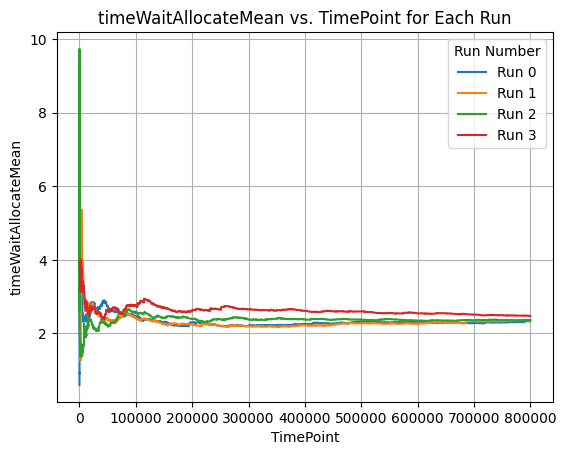

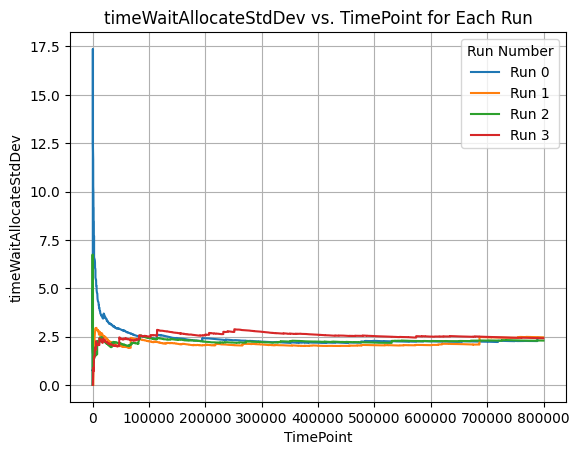

In [46]:
plot_matrix_mean_std_dev(time_points_mat, disk_load_mean_stddev_mat, 'diskLoad')
plot_matrix_mean_std_dev(time_points_mat, io_channel_load_mean_stddev_mat, 'ioChannelLoad')
plot_matrix_mean_std_dev(time_points_mat, processors_load_mean_stddev_mat, 'processorsLoad')
plot_matrix_mean_std_dev(time_points_mat, use_of_page_mean_stddev_mat, 'useOfPage')
plot_matrix_mean_std_dev(time_points_mat, total_wait_allocate_stddev_mat, 'totalWaitAllocate')
plot_matrix_mean_std_dev(time_in_system_time_points_mat, time_in_system_mean_stddev_mat, 'timeInSystem')
plot_matrix_mean_std_dev(time_wait_allocate_time_points_mat, time_wait_allocate_mean_stddev_mat, 'timeWaitAllocate')


In [47]:
transit_period_start_at = 600000

In [48]:
common_props_stable = common_props_raw[common_props_raw['timePoint'] > transit_period_start_at]
time_in_system_stable = time_in_system_raw[time_in_system_raw['timePoint'] > transit_period_start_at]
time_wait_allocate_stable = time_wait_allocate_raw[time_wait_allocate_raw['timePoint'] > transit_period_start_at]

In [49]:
def show_hist(data, col_name: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col_name], bins=50, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.grid(True)

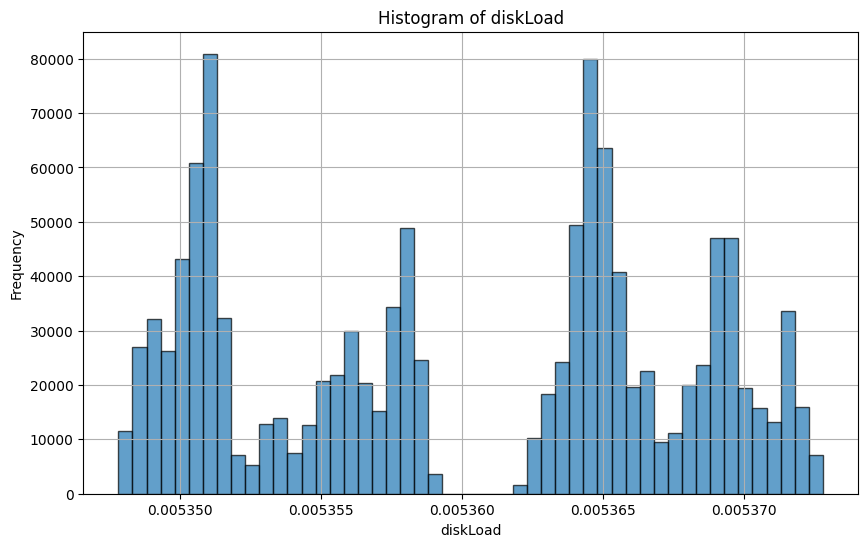

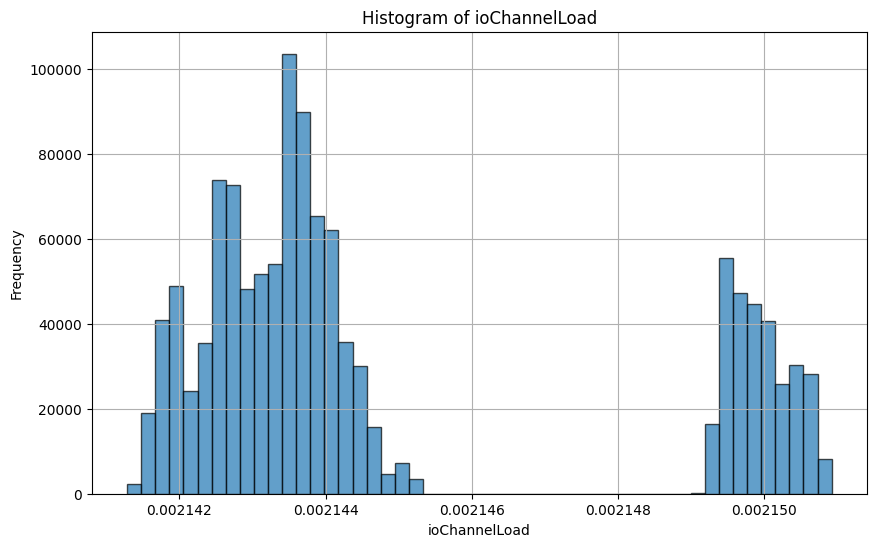

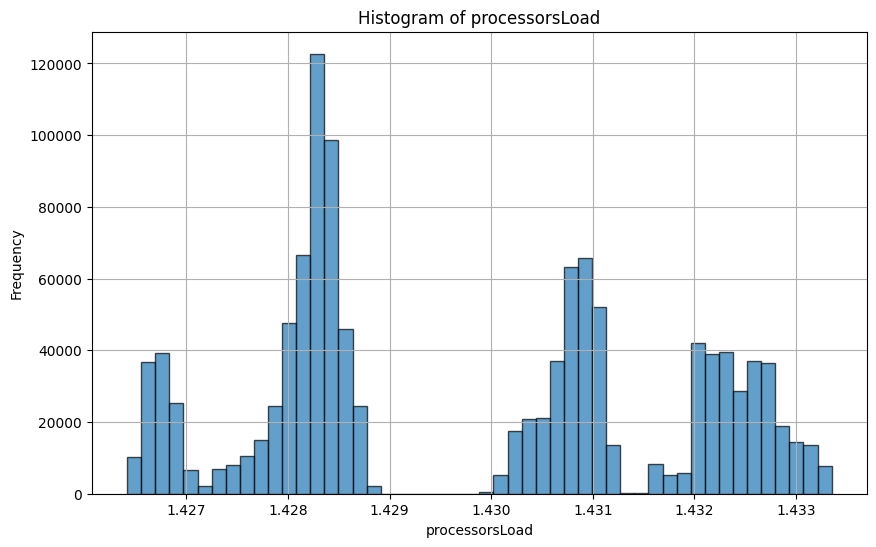

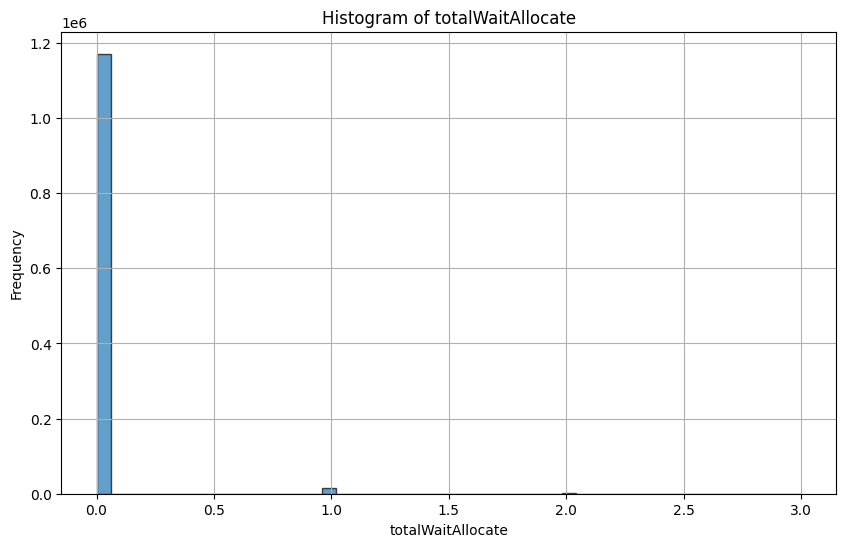

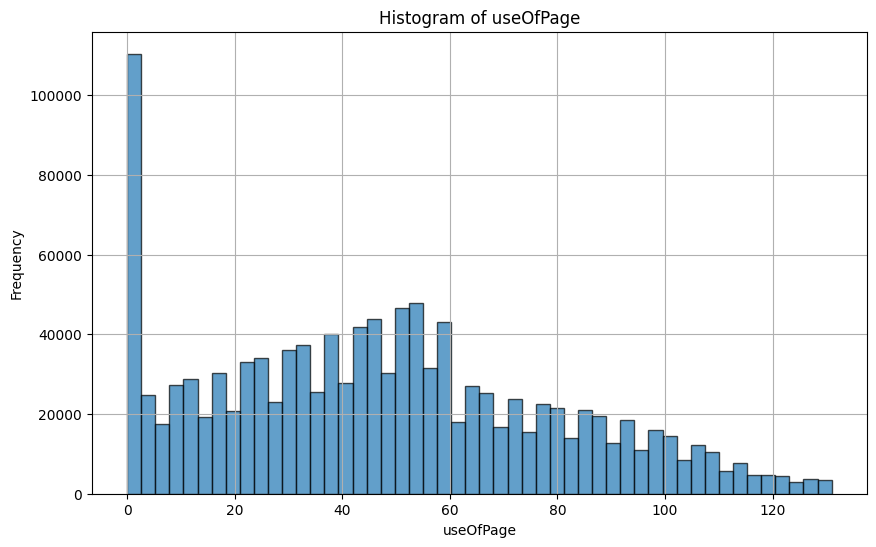

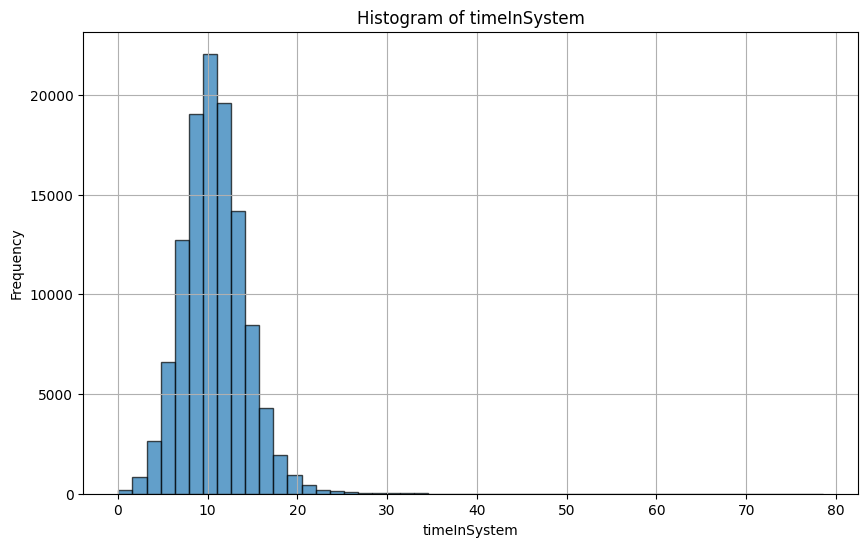

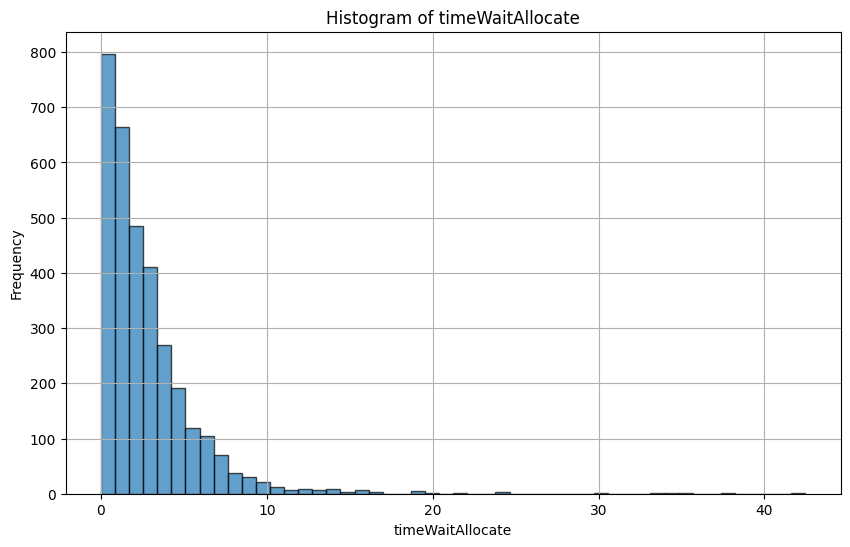

In [50]:
show_hist(common_props_stable, 'diskLoad')
show_hist(common_props_stable, 'ioChannelLoad')
show_hist(common_props_stable, 'processorsLoad')
show_hist(common_props_stable, 'totalWaitAllocate')
show_hist(common_props_stable, 'useOfPage')
show_hist(time_in_system_stable, 'timeInSystem')
show_hist(time_wait_allocate_stable, 'timeWaitAllocate')

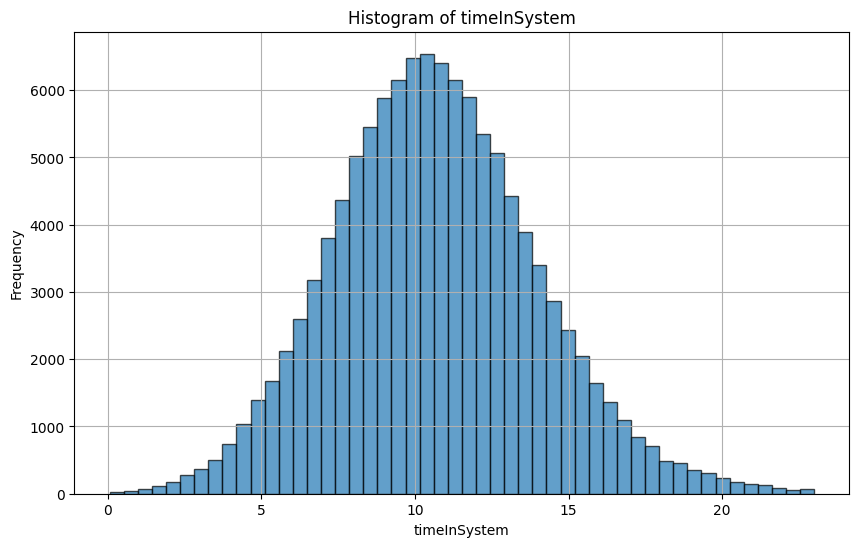

In [52]:
time_in_system_stable_filtered = time_in_system_stable[time_in_system_stable['timeInSystem'] < 23]
show_hist(time_in_system_stable_filtered, 'timeInSystem')

In [ ]:
def plot_hist_with_normal(data: Sequence[float], mean: float, std_dev: float) -> None:
    count, bins, _ = plt.hist(data, bins='sturges', density=True, alpha=0.6, label='Histogram')
    x = np.linspace(bins[0], bins[-1], 1000)
    pdf = norm.pdf(x, mean, std_dev)
    plt.plot(x, pdf, 'r-', lw=2, label='Normal Distribution')
    plt.title('Histogram with Normal Distribution Overlay')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

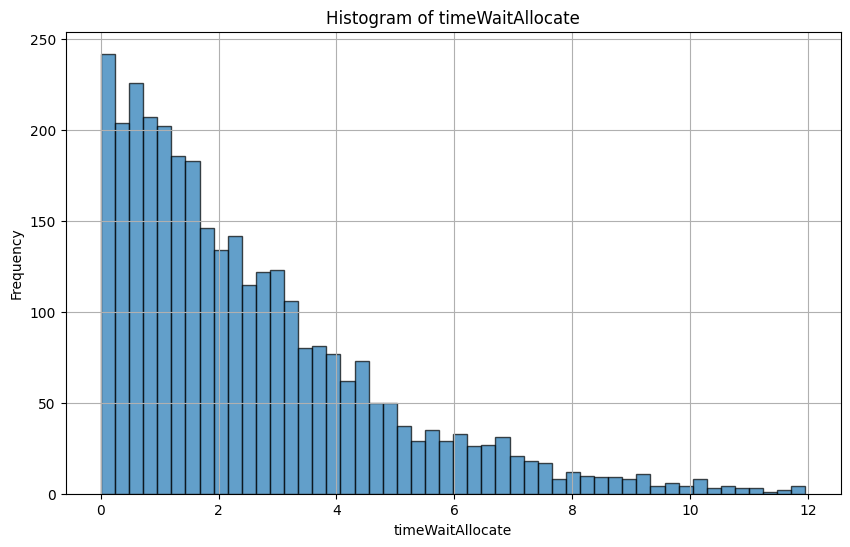

In [53]:
time_wait_allocate_stable_filtered = time_wait_allocate_stable[time_wait_allocate_stable['timeWaitAllocate'] < 12]
show_hist(time_wait_allocate_stable_filtered, 'timeWaitAllocate')